<a href="https://colab.research.google.com/github/mcardenas2003/ISEN427-Baseball-Project/blob/main/umpire2_again.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import expit as logistic
import xarray as xr
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score


az.style.use("arviz-darkgrid")

In [18]:
#ump2_orig = pd.read_csv('https://raw.githubusercontent.com/lekhapriya/ISEN_427-627_Project_2025/refs/heads/main/Umpire_2.csv')
ump2_orig = pd.read_csv('Umpire_2.csv')

In [19]:
def clean_df(orig_df):
    """
    Pitch types:
        ['SI' 'AB' 'SL' 'FC' 'CH' 'CU' 'FF' 'FS' 'EP' 'KC' 'FO' 'KN' 'SC' 'ST'
         'SV' 'CS' 'FA']
    Handedness: R=1, L=0
    Description: 'ball': 0, 'called_strike': 1
    Error in decision: 'correct': 0, 'incorrect': 1
    """
    df = orig_df.copy()
    # Drop nulls
    df = df.dropna()

    # Map pitch types to binary columns
    unique_pt = df['pitch_type'].unique()
    fastballs = ['FF', 'FA', 'FT', 'SI', 'FC'] # 4 seam, 4 seam again, two seam, sinker, cutter
    changeups = ['CH', 'EP', 'FO', 'FS'] # Change, ephus, fork, split
    off_speed = ['SL', 'CU', 'ST', 'SV', 'CS'] # Slider, curve, sweeper, slurve, slow curve
    rare = ['KC', 'KN', 'SC'] # Knucle curve, knuckle ball, screwball
    # AB and AS are 'automatic ball/strike' so they are not included. This happens when something like a pitch clock violation occurs
    # Against the pitcher or the hitter

    # Create new binary columns
    df['fastball'] = df['pitch_type'].isin(fastballs).astype(int)
    df['changeup'] = df['pitch_type'].isin(changeups).astype(int)
    df['off_speed'] = df['pitch_type'].isin(off_speed).astype(int)
    df['rare'] = df['pitch_type'].isin(rare).astype(int)

    # Drop ptich_type column since it is not categorical
    df = df.drop(columns='pitch_type')

    # Same with error
    df['error_in_decision'] = df['error_in_decision'].map({'correct': 0, 'incorrect': 1})

    # Fix handedness
    df['stand'] = df['stand'].map({'R': 1, 'L': 0})
    df['p_throws'] = df['p_throws'].map({'R': 1, 'L': 0})

    df['description'] = df['description'].map({'ball': 0, 'called_strike': 1})
    df['full_count'] = ((df['balls'] == 3) & (df['strikes'] == 2)).astype(int)

    # Max min scale the data to make coefficienst more interpretable
    columns_to_scale = df.drop(columns=['error_in_decision', 'fastball', 'changeup', 'off_speed', 'rare']).columns
    scaler = StandardScaler()
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    return df


ump2 = clean_df(ump2_orig)

In [20]:
ump2

,balls,strikes,release_speed,release_pos_x,release_pos_z,description,zone,stand,p_throws,game_year,...,at_bat_number,pitch_number,home_score,away_score,all_star_player,fastball,changeup,off_speed,rare,full_count
0,-0.783728,-0.850177,-0.878368,-0.269380,1.117554,-0.707829,0.196294,-1.154060,0.641618,-1.531934,...,-1.651897,-0.943120,-0.881999,-0.930627,1.338343,1,0,0,0,-0.155754
1,0.313540,-0.850177,-0.812767,-0.213772,0.921952,-0.707829,0.980590,-1.154060,0.641618,-1.531934,...,-1.651897,-0.297843,-0.881999,-0.930627,1.338343,1,0,0,0,-0.155754
2,1.410809,-0.850177,-0.976770,-0.223882,0.902392,-0.707829,-0.849433,-1.154060,0.641618,-1.531934,...,-1.651897,0.347435,-0.881999,-0.930627,1.338343,1,0,0,0,-0.155754
3,2.508077,-0.850177,-1.107972,-0.274436,1.097994,1.412771,-1.372296,-1.154060,0.641618,-1.531934,...,-1.651897,0.992712,-0.881999,-0.930627,1.338343,1,0,0,0,-0.155754
4,-0.783728,-0.850177,-0.566762,-0.269380,1.058874,-0.707829,0.980590,0.866506,0.641618,-1.531934,...,-1.607127,-0.943120,-0.881999,-0.930627,1.338343,1,0,0,0,-0.155754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53620,-0.783728,1.695891,0.154852,-0.380598,-0.936268,-0.707829,0.980590,0.866506,0.641618,1.812307,...,1.302927,0.347435,0.364945,-0.930627,1.338343,0,0,1,0,-0.155754
53621,-0.783728,-0.850177,1.860484,-0.506982,-1.268791,-0.707829,0.196294,0.866506,0.641618,1.812307,...,1.347697,-0.943120,0.364945,-0.930627,1.338343,1,0,0,0,-0.155754
53622,0.313540,-0.850177,1.614479,-0.496872,-1.229671,1.412771,-1.895160,0.866506,0.641618,1.812307,...,1.347697,-0.297843,0.364945,-0.930627,1.338343,1,0,0,0,-0.155754
53623,-0.783728,-0.850177,1.926085,-0.400820,-1.190550,1.412771,-1.110865,0.866506,0.641618,1.812307,...,1.392467,-0.943120,0.364945,-0.930627,1.338343,1,0,0,0,-0.155754


In [21]:
df, df_test, labels_train, labels_test = train_test_split(ump2.drop(columns='error_in_decision'), ump2['error_in_decision'], test_size=0.2, random_state=42)
df['error_in_decision'] = labels_train
# Balance data
undersample = RandomUnderSampler(sampling_strategy='majority')
X_bal, y_bal = undersample.fit_resample(df.drop(columns=['error_in_decision']), df['error_in_decision'])
df = pd.concat([X_bal, y_bal], axis=1)

df_test['error_in_decision'] = labels_test
# df = ump1[0:2000] # ump1.sample(n=200, random_state=42) # Only take a small amount so that the modeling doesn't take 5-ever
# df_test = ump1[2000:4000]
labels = np.array(df['error_in_decision'])
# outcomes_test = np.array(X_test['error_in_decision'])

# Init loocv dict to compare all models
loocv_ump1 = {}
model_accuracies = {}

Pitch Location

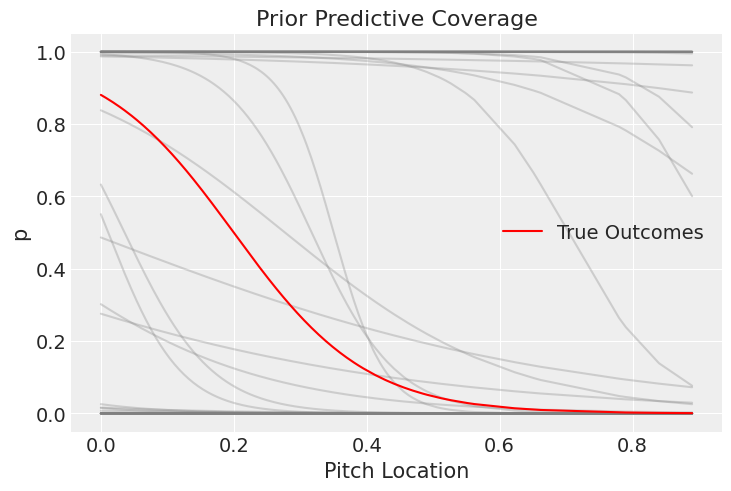

In [8]:
  # Prior checking
# Create synthetic dataset
t_pitch_location = -10
t_intercept = 2
true_p = 1 / (1+np.exp(-(t_intercept + t_pitch_location*df['pitch_location'])))
true_outcomes = np.array((true_p > 0.5).astype(int))

t_mu = t_intercept + (t_pitch_location*df['pitch_location'])
true_p = 1 / (1+np.exp(-t_mu))
true_outcomes = np.array((true_p > 0.5).astype(int))


with pm.Model() as pitch_type_prior:

    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    pitch_location = -pm.HalfNormal("pitch_location", sigma=10) # Negitive values only

    # Logistic transform
    mu = intercept + (pitch_location*df['pitch_location'])
    p = pm.Deterministic('p', pm.math.sigmoid(mu))

    # outcome
    outcome = pm.Bernoulli("outcome", p=p, observed=true_outcomes)

    idata = pm.sample_prior_predictive(draws=50, random_seed=42)




# Get the prior predictive probabilities
p_prior = idata.prior["p"].values  # shape: (draws, obs)

X_sorted_idx = np.argsort(df['pitch_location'])
X_sorted = df['pitch_location'].values[X_sorted_idx]
true_sorted = true_p.iloc[X_sorted_idx]

# p_prior_sorted = p_prior[:, X_sorted_idx]

for sig in idata.prior['p'].values[0]:
    # Sort data
    sig_sort = sig[X_sorted_idx]
    # Plot data
    plt.plot(X_sorted, sig_sort, color='gray', alpha=0.3)


# plt.plot(X_sorted, p_prior_sorted[0][0], color='dodgerblue')

plt.plot(X_sorted, true_sorted, color='red', label='True Outcomes', zorder=3)

plt.xlabel("Pitch Location")
plt.ylabel("p")
plt.title("Prior Predictive Coverage")
plt.legend()
plt.show()

Getting advi samples...


Output()

Tracing mean field...
Plotting posterior...


<Axes: title={'center': 'pitch_location'}>

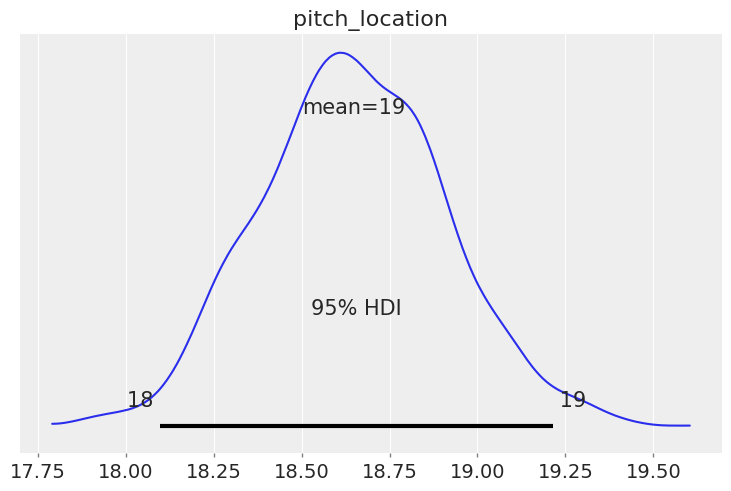

In [9]:
# Create real model, pitch_location
with pm.Model() as m_locaiton:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    pitch_location = -pm.HalfNormal("pitch_location", sigma=10)

    # Likelihood
    mu = intercept + (pitch_location*df['pitch_location'])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    y1 = pm.Bernoulli('y1', p=theta, observed=df['error_in_decision'])

    # ELPD_LOO
    print("Getting advi samples...")
    mean_field = pm.fit(method='advi', obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    # idata1 = pm.sample(draws=1000, idata_kwargs={"log_likelihood":True})
    # idata1.extend(pm.sample_posterior_predictive(idata1))
    # loocv_ump1["m1"] = idata1

print("Tracing mean field...")
trace_location = mean_field.sample(1000)

# add to model comparision dict
loocv_ump1["locaiton"] = trace_location

print("Plotting posterior...")
az.plot_posterior(trace_location, var_names=["pitch_location"], hdi_prob=0.95)

In [22]:
# =====================Get Accuracy=====================
# Init param samples
param_samples = {}

# Make predictions for each posterior sample
n_samples = len(trace_location.posterior['intercept'])
n_obs = len(df_test)

# Initialize predictions array
all_preds = np.zeros((n_samples, n_obs))

# Get samples from each param (generalized for any number of params)
for param in ['intercept', 'pitch_location']:
    param_samples[param] = trace_location.posterior[param].values.flatten()

# Make predictions
for i in range(n_samples):
  # Use df_test!
  mu = param_samples['intercept'][i] - (param_samples['pitch_location'][i]*df_test['pitch_location'])       # !!!!CHANGE THE SIGN HERE IF THE DISTRIBUTION IS NEGITIVE/POSITIVE
  all_preds[i, :] = 1 / (1 + np.exp(-mu))  # sigmoid function

# Make predictions
y_pred_proba = all_preds.mean(axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = f1_score(y_pred, df_test['error_in_decision'])
model_accuracies["location"] = accuracy

# print accuracy
print(f"F1: {accuracy}")
print(f"Number of Category 0: {np.sum(y_pred == 0)}")
print(f"Number of Category 1: {np.sum(y_pred == 1)}")

F1: 0.34488127676138575
Number of Category 0: 4430
Number of Category 1: 6295


Full Count

Getting advi samples...


Output()

Tracing mean field...
Plotting posterior...


<Axes: title={'center': 'full_count'}>

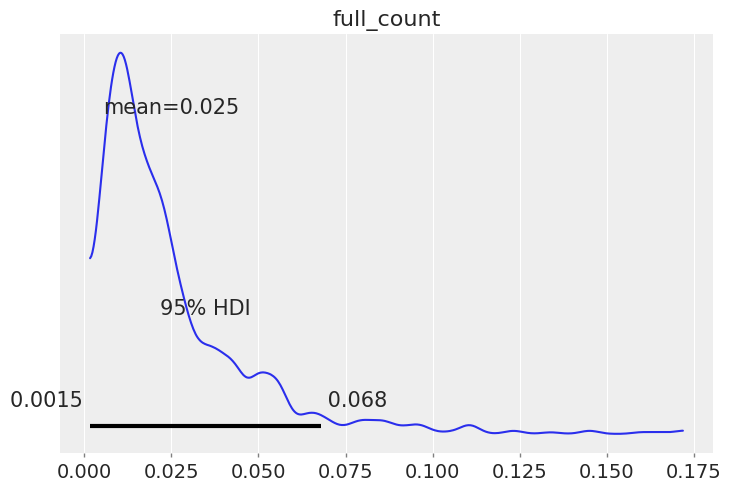

In [23]:
# Create real model, pitch_location
with pm.Model() as m_full_count:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    full_count = -pm.HalfNormal("full_count", sigma=10) # Assuming umpire gets better in full count situations because of the importance of the situation

    # Likelihood
    mu = intercept + (full_count*df['full_count'])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    y1 = pm.Bernoulli('y1', p=theta, observed=df['error_in_decision'])

    # ELPD_LOO
    print("Getting advi samples...")
    mean_field = pm.fit(method='advi', obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    # idata1 = pm.sample(draws=1000, idata_kwargs={"log_likelihood":True})
    # idata1.extend(pm.sample_posterior_predictive(idata1))
    # loocv_ump1["m1"] = idata1

print("Tracing mean field...")
trace_fullCount = mean_field.sample(1000)

# add to model comparision dict
loocv_ump1["full_count"] = trace_fullCount

print("Plotting posterior...")
az.plot_posterior(trace_fullCount, var_names=["full_count"], hdi_prob=0.95)

In [24]:
# =====================Get Accuracy=====================
# Init param samples
param_samples = {}

# Make predictions for each posterior sample
n_samples = len(trace_fullCount.posterior['intercept'])
n_obs = len(df_test)

# Initialize predictions array
all_preds = np.zeros((n_samples, n_obs))

# Get samples from each param (generalized for any number of params)
for param in ['intercept', 'full_count']:
    param_samples[param] = trace_fullCount.posterior[param].values.flatten()

# Make predictions
for i in range(n_samples):
  # Use df_test!
  mu = param_samples['intercept'][i] - (param_samples['full_count'][i]*df_test['full_count'])       # !!!!CHANGE THE SIGN HERE IF THE DISTRIBUTION IS NEGITIVE/POSITIVE
  all_preds[i, :] = 1 / (1 + np.exp(-mu))  # sigmoid function

# Make predictions
y_pred_proba = all_preds.mean(axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = f1_score(y_pred, df_test['error_in_decision'])
model_accuracies["full_count"] = accuracy

# print accuracy
print(f"F1: {accuracy}")
print(f"Number of Category 0: {np.sum(y_pred == 0)}")
print(f"Number of Category 1: {np.sum(y_pred == 1)}")

F1: 0.23241332884550656
Number of Category 0: 253
Number of Category 1: 10472


Delta Run

Getting advi samples...


Output()

Tracing mean field...
Plotting posterior...


<Axes: title={'center': 'delta_run_exp'}>

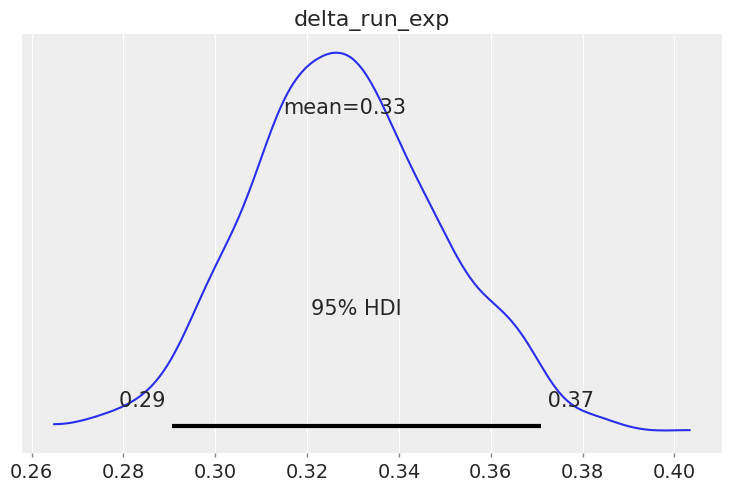

In [25]:
# Create real model, pitch_location
with pm.Model() as m_run_exp:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    delta_run_exp = -pm.HalfNormal("delta_run_exp", sigma=10) # Assuming umpire gets better in situations where more runs can be scored (he will be more focused)

    # Likelihood
    mu = intercept + (delta_run_exp*df['delta_run_exp'])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    y1 = pm.Bernoulli('y1', p=theta, observed=df['error_in_decision'])

    # ELPD_LOO
    print("Getting advi samples...")
    mean_field = pm.fit(method='advi', obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    # idata1 = pm.sample(draws=1000, idata_kwargs={"log_likelihood":True})
    # idata1.extend(pm.sample_posterior_predictive(idata1))
    # loocv_ump1["m1"] = idata1

print("Tracing mean field...")
trace_delta_run_exp = mean_field.sample(1000)

# add to model comparision dict
loocv_ump1["delta_run_exp"] = trace_delta_run_exp

print("Plotting posterior...")
az.plot_posterior(trace_delta_run_exp, var_names=["delta_run_exp"], hdi_prob=0.95)


In [26]:
# =====================Get Accuracy=====================
# Init param samples
param_samples = {}

# Make predictions for each posterior sample
n_samples = len(trace_delta_run_exp.posterior['intercept'])
n_obs = len(df_test)

# Initialize predictions array
all_preds = np.zeros((n_samples, n_obs))

# Get samples from each param (generalized for any number of params)
for param in ['intercept', 'delta_run_exp']:
    param_samples[param] = trace_delta_run_exp.posterior[param].values.flatten()

# Make predictions
for i in range(n_samples):
  # Use df_test!
  mu = param_samples['intercept'][i] - (param_samples['delta_run_exp'][i]*df_test['delta_run_exp'])       # !!!!CHANGE THE SIGN HERE IF THE DISTRIBUTION IS NEGITIVE/POSITIVE
  all_preds[i, :] = 1 / (1 + np.exp(-mu))  # sigmoid function

# Make predictions
y_pred_proba = all_preds.mean(axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = f1_score(y_pred, df_test['error_in_decision'])
model_accuracies["delta_run_exp"] = accuracy

# print accuracy
print(f"F1: {accuracy}")
print(f"Number of Category 0: {np.sum(y_pred == 0)}")
print(f"Number of Category 1: {np.sum(y_pred == 1)}")

F1: 0.2853234316982607
Number of Category 0: 7020
Number of Category 1: 3705


Fastball

Getting advi samples...


Output()

Tracing mean field...
Plotting posterior...


<Axes: title={'center': 'fastball'}>

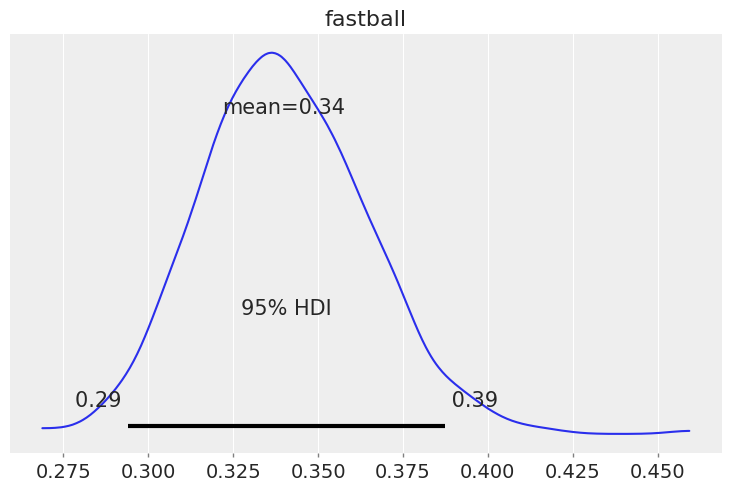

In [27]:
# Create real model, pitch_location
with pm.Model() as m_fastball:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    fastball = pm.HalfNormal("fastball", sigma=10) # Assuming the umpire has a harder time calling fastballs correctly because they are thrown faster

    # Likelihood
    mu = intercept + (fastball*df['fastball'])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    y1 = pm.Bernoulli('y1', p=theta, observed=df['error_in_decision'])

    # ELPD_LOO
    print("Getting advi samples...")
    mean_field = pm.fit(method='advi', obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    # idata1 = pm.sample(draws=1000, idata_kwargs={"log_likelihood":True})
    # idata1.extend(pm.sample_posterior_predictive(idata1))
    # loocv_ump1["m1"] = idata1

print("Tracing mean field...")
trace_fastball = mean_field.sample(1000)

# add to model comparision dict
loocv_ump1["fastball"] = trace_fastball

print("Plotting posterior...")
az.plot_posterior(trace_fastball, var_names=["fastball"], hdi_prob=0.95)


In [28]:
# =====================Get Accuracy=====================
# Init param samples
param_samples = {}

# Make predictions for each posterior sample
n_samples = len(trace_fastball.posterior['intercept'])
n_obs = len(df_test)

# Initialize predictions array
all_preds = np.zeros((n_samples, n_obs))

# Get samples from each param (generalized for any number of params)
for param in ['intercept', 'fastball']:
    param_samples[param] = trace_fastball.posterior[param].values.flatten()

# Make predictions
for i in range(n_samples):
  # Use df_test!
  mu = param_samples['intercept'][i] + (param_samples['fastball'][i]*df_test['fastball'])       # !!!!CHANGE THE SIGN HERE IF THE DISTRIBUTION IS NEGITIVE/POSITIVE
  all_preds[i, :] = 1 / (1 + np.exp(-mu))  # sigmoid function

# Make predictions
y_pred_proba = all_preds.mean(axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = f1_score(y_pred, df_test['error_in_decision'])
model_accuracies["fastball"] = accuracy

# print accuracy
print(f"F1: {accuracy}")
print(f"Number of Category 0: {np.sum(y_pred == 0)}")
print(f"Number of Category 1: {np.sum(y_pred == 1)}")

F1: 0.24575257238573822
Number of Category 0: 3779
Number of Category 1: 6946


Pitch Number

Getting advi samples...


Output()

Tracing mean field...
Plotting posterior...


<Axes: title={'center': 'pitch_number'}>

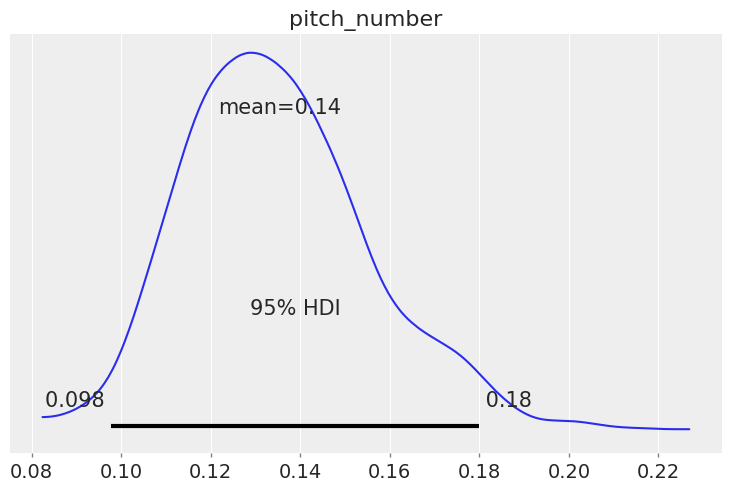

In [29]:
# Create real model, pitch_location
with pm.Model() as m_pitch_number:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    # Assuming umpire gets tired and less accurate the longer the at bat goes on
    # ^^^ This was incorrect, coefficient actually wants to be negitive, meaning he gets more accurate the longer the at bat goes on
    pitch_number = -pm.HalfNormal("pitch_number", sigma=10)

    # Likelihood
    mu = intercept + (pitch_number*df['pitch_number'])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    y1 = pm.Bernoulli('y1', p=theta, observed=df['error_in_decision'])

    # ELPD_LOO
    print("Getting advi samples...")
    mean_field = pm.fit(method='advi', obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    # idata1 = pm.sample(draws=1000, idata_kwargs={"log_likelihood":True})
    # idata1.extend(pm.sample_posterior_predictive(idata1))
    # loocv_ump1["m1"] = idata1

print("Tracing mean field...")
trace_pitch_number = mean_field.sample(1000)

# add to model comparision dict
loocv_ump1["pitch_number"] = trace_pitch_number

print("Plotting posterior...")
az.plot_posterior(trace_pitch_number, var_names=["pitch_number"], hdi_prob=0.95)

In [30]:
# =====================Get Accuracy=====================
# Init param samples
param_samples = {}

# Make predictions for each posterior sample
n_samples = len(trace_pitch_number.posterior['intercept'])
n_obs = len(df_test)

# Initialize predictions array
all_preds = np.zeros((n_samples, n_obs))

# Get samples from each param (generalized for any number of params)
for param in ['intercept', 'pitch_number']:
    param_samples[param] = trace_pitch_number.posterior[param].values.flatten()

# Make predictions
for i in range(n_samples):
  # Use df_test!
  mu = param_samples['intercept'][i] - (param_samples['pitch_number'][i]*df_test['pitch_number'])       # !!!!CHANGE THE SIGN HERE IF THE DISTRIBUTION IS NEGITIVE
  all_preds[i, :] = 1 / (1 + np.exp(-mu))  # sigmoid function

# Make predictions
y_pred_proba = all_preds.mean(axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = f1_score(y_pred, df_test['error_in_decision'])
model_accuracies["pitch_number"] = accuracy

# print accuracy
print(f"F1: {accuracy}")
print(f"Number of Category 0: {np.sum(y_pred == 0)}")
print(f"Number of Category 1: {np.sum(y_pred == 1)}")

F1: 0.23857160947195138
Number of Category 0: 4240
Number of Category 1: 6485


Plootting F1 scores

([0, 1, 2, 3, 4],
 [Text(0, 0, 'location'),
  Text(1, 0, 'full_count'),
  Text(2, 0, 'delta_run_exp'),
  Text(3, 0, 'fastball'),
  Text(4, 0, 'pitch_number')])

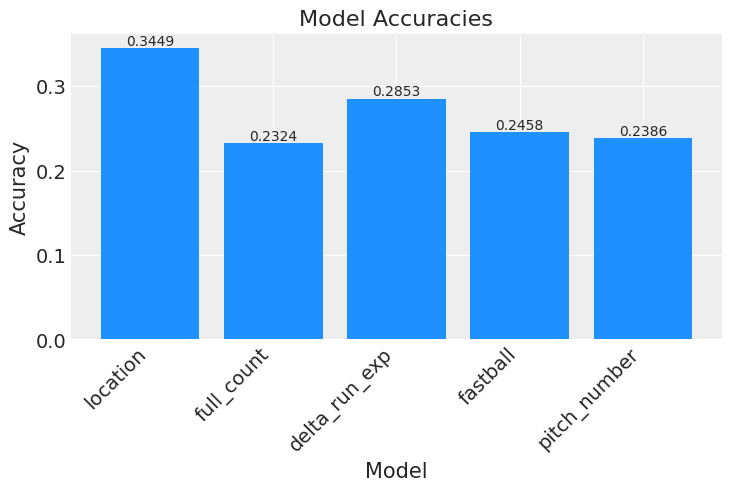

In [31]:
# Bar chart
import matplotlib.pyplot as plt

# Extract model names and accuracies
model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

# Create bar chart
plt.bar(model_names, accuracies, color='dodgerblue')

# Add values on top of bars
for i, v in enumerate(accuracies):
    plt.text(i, v, str(round(v, 4)), ha='center', va='bottom')

# Customize chart
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracies")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

Creating combined models

In [32]:
combined_f1 = {}

Pitch location and delta run exp

Getting advi samples...


Output()

Tracing mean field...
Plotting posterior...


array([<Axes: title={'center': 'pitch_location'}>,
       <Axes: title={'center': 'delta_run_exp'}>], dtype=object)

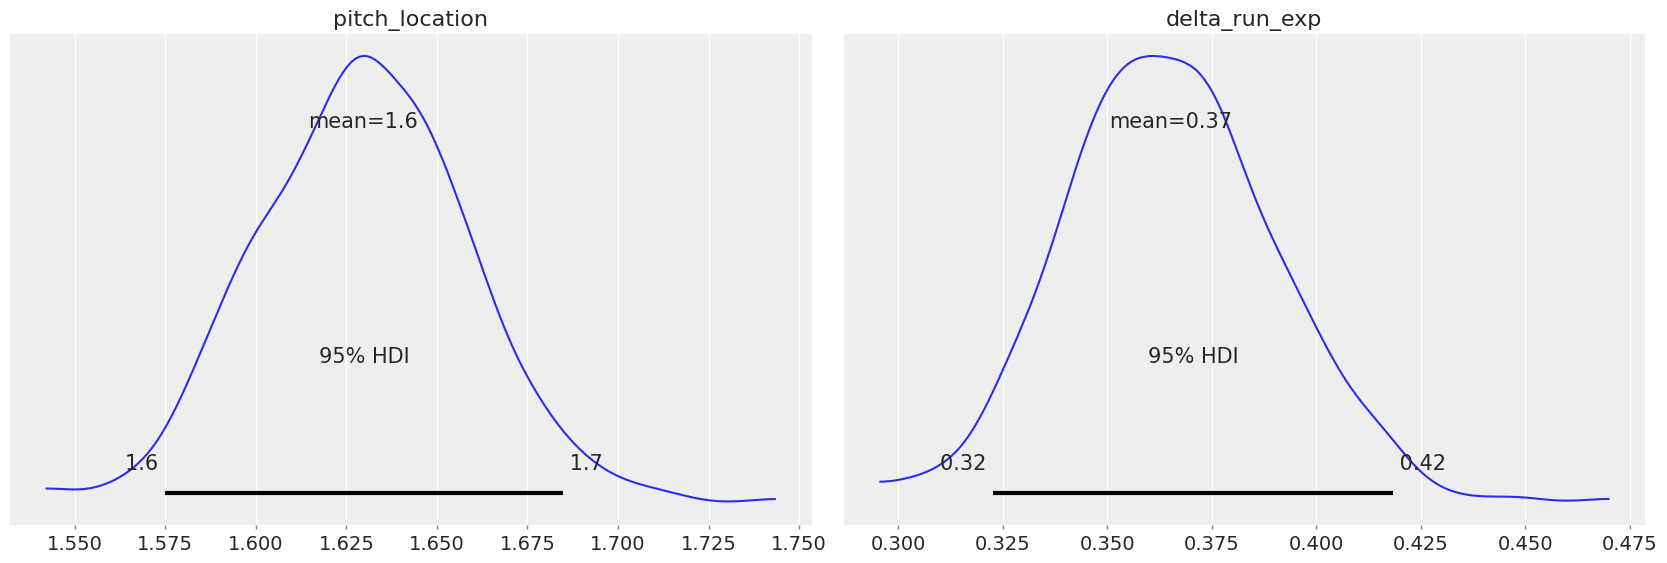

In [33]:
# Combine location and delta_run_exp
with pm.Model() as m_locaiton_runExp:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    pitch_location = -pm.HalfNormal("pitch_location", sigma=10)
    delta_run_exp = -pm.HalfNormal("delta_run_exp", sigma=10) # Assuming umpire gets better in situations where more runs can be scored (he will be more focused)

    # Likelihood
    mu = intercept + (pitch_location*df['pitch_location']) + (delta_run_exp*df['delta_run_exp'])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    y1 = pm.Bernoulli('y1', p=theta, observed=df['error_in_decision'])

    # ELPD_LOO
    print("Getting advi samples...")
    mean_field = pm.fit(method='advi', obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    # idata1 = pm.sample(draws=1000, idata_kwargs={"log_likelihood":True})
    # idata1.extend(pm.sample_posterior_predictive(idata1))
    # loocv_ump1["m1"] = idata1

print("Tracing mean field...")
trace_locaiton_runExp = mean_field.sample(1000)

# add to model comparision dict
loocv_ump1["locaiton_runExp"] = trace_locaiton_runExp

print("Plotting posterior...")
az.plot_posterior(trace_locaiton_runExp, var_names=['pitch_location', "delta_run_exp"], hdi_prob=0.95)

In [34]:
# =====================Get Accuracy=====================
# Init param samples
param_samples = {}

# Make predictions for each posterior sample
n_samples = len(trace_locaiton_runExp.posterior['intercept'])
n_obs = len(df_test)

# Initialize predictions array
all_preds = np.zeros((n_samples, n_obs))

# Get samples from each param (generalized for any number of params)
for param in ['intercept', 'pitch_location', "delta_run_exp"]:
    param_samples[param] = trace_locaiton_runExp.posterior[param].values.flatten()

# Make predictions
for i in range(n_samples):
  # Use df_test!
  mu = param_samples['intercept'][i] + (
      - (param_samples['pitch_location'][i]*df_test['pitch_location'])
      - (param_samples['delta_run_exp'][i]*df_test['delta_run_exp'])     # !!!!CHANGE THE SIGN HERE IF THE DISTRIBUTION IS NEGITIVE
      )
  all_preds[i, :] = 1 / (1 + np.exp(-mu))  # sigmoid function

# Make predictions
y_pred_proba = all_preds.mean(axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = f1_score(y_pred, df_test['error_in_decision'])
combined_f1["locaiton_runExp"] = accuracy

# print accuracy
print(f"F1: {accuracy}")
print(f"Number of Category 0: {np.sum(y_pred == 0)}")
print(f"Number of Category 1: {np.sum(y_pred == 1)}")

F1: 0.4036853779218563
Number of Category 0: 6276
Number of Category 1: 4449


delta run exp and fastball

Getting advi samples...


Output()

Tracing mean field...
Plotting posterior...


array([<Axes: title={'center': 'fastball'}>,
       <Axes: title={'center': 'delta_run_exp'}>], dtype=object)

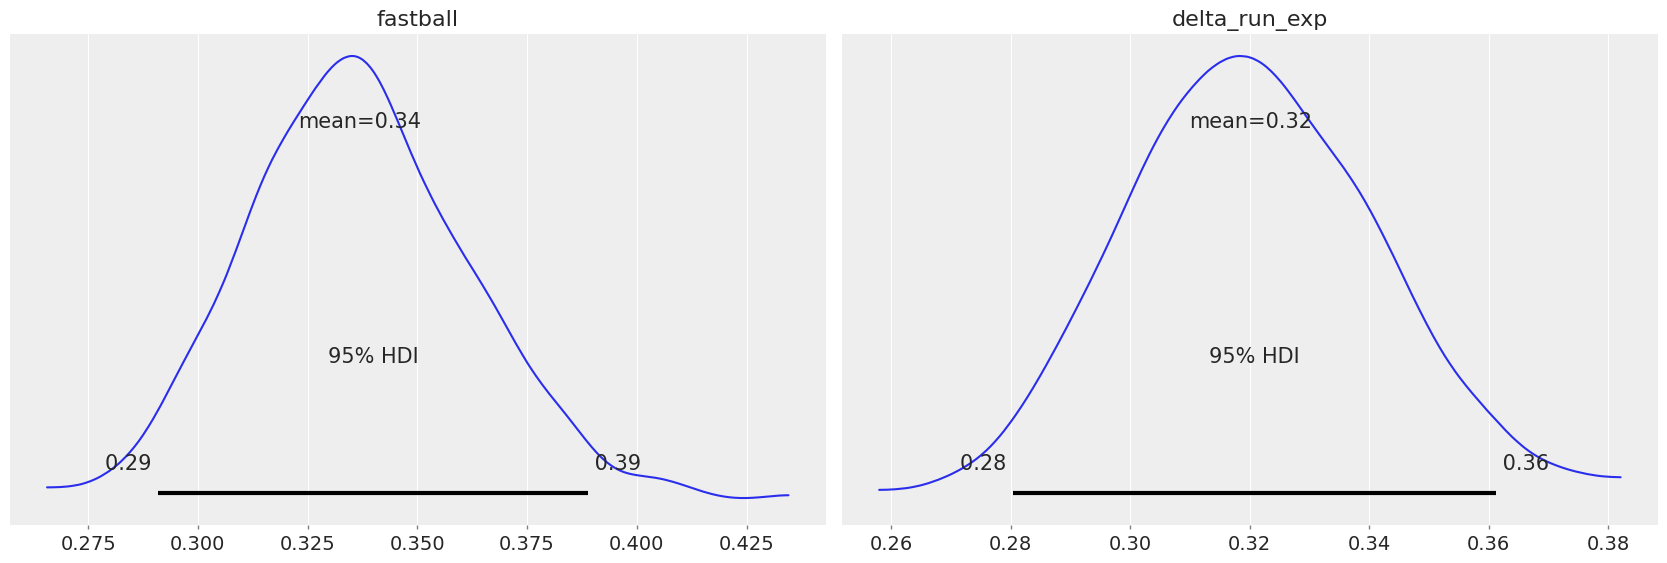

In [35]:
# Combine delta_run_exp and fastball
with pm.Model() as m_fastball_runExp:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    fastball = pm.HalfNormal("fastball", sigma=10) # Assuming the umpire has a harder time calling fastballs correctly because they are thrown faster
    delta_run_exp = -pm.HalfNormal("delta_run_exp", sigma=10) # Assuming umpire gets better in situations where more runs can be scored (he will be more focused)

    # Likelihood
    mu = intercept + (fastball*df['fastball']) + (delta_run_exp*df['delta_run_exp'])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    y1 = pm.Bernoulli('y1', p=theta, observed=df['error_in_decision'])

    # ELPD_LOO
    print("Getting advi samples...")
    mean_field = pm.fit(method='advi', obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    # idata1 = pm.sample(draws=1000, idata_kwargs={"log_likelihood":True})
    # idata1.extend(pm.sample_posterior_predictive(idata1))
    # loocv_ump1["m1"] = idata1

print("Tracing mean field...")
trace_fastball_runExp = mean_field.sample(1000)

# add to model comparision dict
loocv_ump1["fastball_runExp"] = trace_fastball_runExp

print("Plotting posterior...")
az.plot_posterior(trace_fastball_runExp, var_names=['fastball', "delta_run_exp"], hdi_prob=0.95)

In [36]:
# =====================Get Accuracy=====================
# Init param samples
param_samples = {}

# Make predictions for each posterior sample
n_samples = len(trace_fastball_runExp.posterior['intercept'])
n_obs = len(df_test)

# Initialize predictions array
all_preds = np.zeros((n_samples, n_obs))

# Get samples from each param (generalized for any number of params)
for param in ['intercept', 'fastball', "delta_run_exp"]:
    param_samples[param] = trace_fastball_runExp.posterior[param].values.flatten()

# Make predictions
for i in range(n_samples):
  # Use df_test!
  mu = param_samples['intercept'][i] + (
      + (param_samples['fastball'][i]*df_test['fastball'])
      - (param_samples['delta_run_exp'][i]*df_test['delta_run_exp'])     # !!!!CHANGE THE SIGN HERE IF THE DISTRIBUTION IS NEGITIVE
      )
  all_preds[i, :] = 1 / (1 + np.exp(-mu))  # sigmoid function

# Make predictions
y_pred_proba = all_preds.mean(axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = f1_score(y_pred, df_test['error_in_decision'])
combined_f1["fastball_runExp"] = accuracy

# print accuracy
print(f"F1: {accuracy}")
print(f"Number of Category 0: {np.sum(y_pred == 0)}")
print(f"Number of Category 1: {np.sum(y_pred == 1)}")

F1: 0.26034997865983783
Number of Category 0: 5108
Number of Category 1: 5617


Pitch location and number

Getting advi samples...


Output()

Tracing mean field...
Plotting posterior...


array([<Axes: title={'center': 'pitch_location'}>,
       <Axes: title={'center': 'pitch_number'}>], dtype=object)

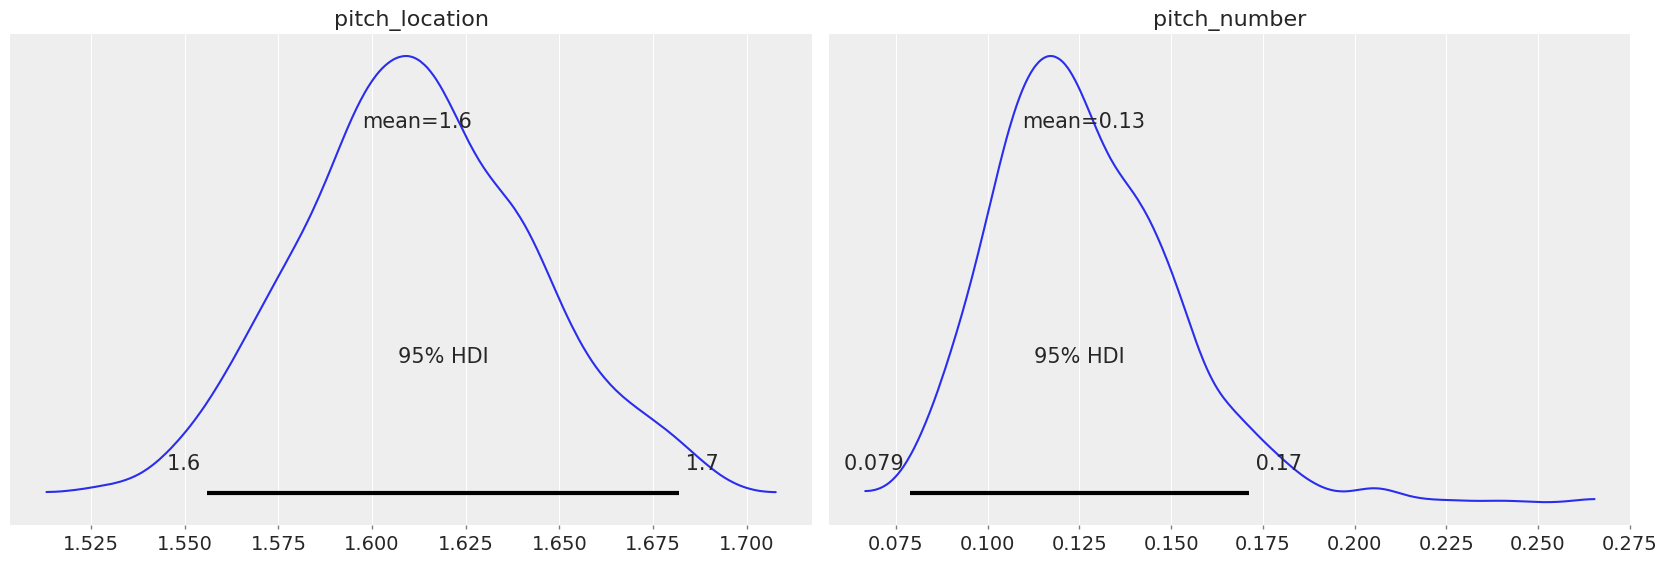

In [37]:
# Combine location and pitch_number
with pm.Model() as m_locaiton_number:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    pitch_location = -pm.HalfNormal("pitch_location", sigma=10)
    # Assuming umpire gets tired and less accurate the longer the at bat goes on
    # ^^^ This was incorrect, coefficient actually wants to be negitive, meaning he gets more accurate the longer the at bat goes on
    pitch_number = -pm.HalfNormal("pitch_number", sigma=10)

    # Likelihood
    mu = intercept + (pitch_location*df['pitch_location']) + (pitch_number*df['pitch_number'])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    y1 = pm.Bernoulli('y1', p=theta, observed=df['error_in_decision'])

    # ELPD_LOO
    print("Getting advi samples...")
    mean_field = pm.fit(method='advi', obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    # idata1 = pm.sample(draws=1000, idata_kwargs={"log_likelihood":True})
    # idata1.extend(pm.sample_posterior_predictive(idata1))
    # loocv_ump1["m1"] = idata1

print("Tracing mean field...")
trace_locaiton_number = mean_field.sample(1000)

# add to model comparision dict
loocv_ump1["locaiton_number"] = trace_locaiton_number

print("Plotting posterior...")
az.plot_posterior(trace_locaiton_number, var_names=['pitch_location', "pitch_number"], hdi_prob=0.95)

In [38]:
# =====================Get Accuracy=====================
# Init param samples
param_samples = {}

# Make predictions for each posterior sample
n_samples = len(trace_locaiton_number.posterior['intercept'])
n_obs = len(df_test)

# Initialize predictions array
all_preds = np.zeros((n_samples, n_obs))

# Get samples from each param (generalized for any number of params)
for param in ['intercept', 'pitch_location', "pitch_number"]:
    param_samples[param] = trace_locaiton_number.posterior[param].values.flatten()

# Make predictions
for i in range(n_samples):
  # Use df_test!
  mu = param_samples['intercept'][i] + (
      - (param_samples['pitch_location'][i]*df_test['pitch_location'])
      - (param_samples['pitch_number'][i]*df_test['pitch_number'])     # !!!!CHANGE THE SIGN HERE IF THE DISTRIBUTION IS NEGITIVE
      )
  all_preds[i, :] = 1 / (1 + np.exp(-mu))  # sigmoid function

# Make predictions
y_pred_proba = all_preds.mean(axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = f1_score(y_pred, df_test['error_in_decision'])
combined_f1["locaiton_number"] = accuracy

# print accuracy
print(f"F1: {accuracy}")
print(f"Number of Category 0: {np.sum(y_pred == 0)}")
print(f"Number of Category 1: {np.sum(y_pred == 1)}")

F1: 0.386455525606469
Number of Category 0: 6201
Number of Category 1: 4524


Tring pitch location and full count

Getting advi samples...


Output()

Tracing mean field...
Plotting posterior...


array([<Axes: title={'center': 'pitch_location'}>,
       <Axes: title={'center': 'full_count'}>], dtype=object)

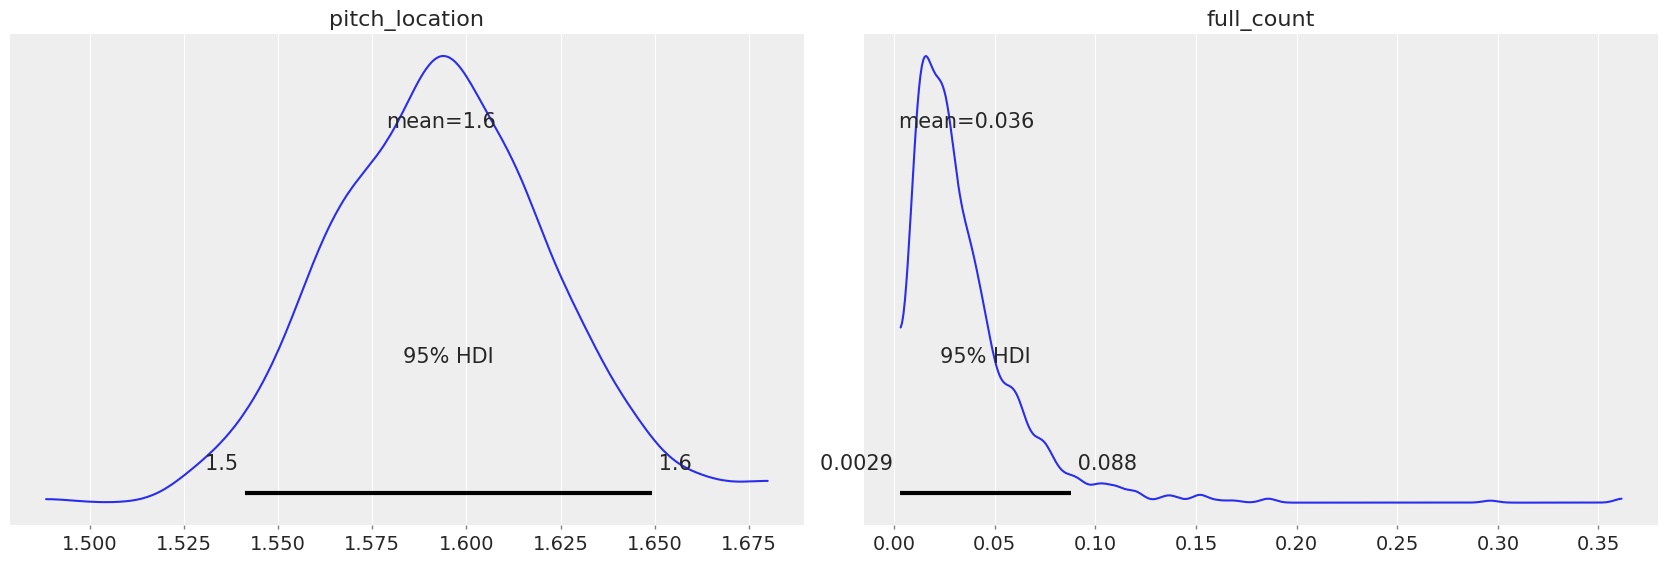

In [39]:
# Combine location and full_count
with pm.Model() as m_locaiton_fullCount:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    pitch_location = -pm.HalfNormal("pitch_location", sigma=10)
    full_count = -pm.HalfNormal("full_count", sigma=10) # Assuming umpire gets better in full count situations because of the importance of the situation


    # Likelihood
    mu = intercept + (pitch_location*df['pitch_location']) + (full_count*df['full_count'])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    y1 = pm.Bernoulli('y1', p=theta, observed=df['error_in_decision'])

    # ELPD_LOO
    print("Getting advi samples...")
    mean_field = pm.fit(method='advi', obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    # idata1 = pm.sample(draws=1000, idata_kwargs={"log_likelihood":True})
    # idata1.extend(pm.sample_posterior_predictive(idata1))
    # loocv_ump1["m1"] = idata1

print("Tracing mean field...")
trace_locaiton_fullCount = mean_field.sample(1000)

# add to model comparision dict
loocv_ump1["locaiton_fullCount"] = trace_locaiton_fullCount

print("Plotting posterior...")
az.plot_posterior(trace_locaiton_fullCount, var_names=['pitch_location', "full_count"], hdi_prob=0.95)

In [40]:
# =====================Get Accuracy=====================
# Init param samples
param_samples = {}

# Make predictions for each posterior sample
n_samples = len(trace_locaiton_fullCount.posterior['intercept'])
n_obs = len(df_test)

# Initialize predictions array
all_preds = np.zeros((n_samples, n_obs))

# Get samples from each param (generalized for any number of params)
for param in ['intercept', 'pitch_location', "full_count"]:
    param_samples[param] = trace_locaiton_fullCount.posterior[param].values.flatten()

# Make predictions
for i in range(n_samples):
  # Use df_test!
  mu = param_samples['intercept'][i] + (
      - (param_samples['full_count'][i]*df_test['full_count'])
      - (param_samples['pitch_location'][i]*df_test['pitch_location'])     # !!!!CHANGE THE SIGN HERE IF THE DISTRIBUTION IS NEGITIVE
      )
  all_preds[i, :] = 1 / (1 + np.exp(-mu))  # sigmoid function

# Make predictions
y_pred_proba = all_preds.mean(axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = f1_score(y_pred, df_test['error_in_decision'])
combined_f1["locaiton_fullCount"] = accuracy

# print accuracy
print(f"F1: {accuracy}")
print(f"Number of Category 0: {np.sum(y_pred == 0)}")
print(f"Number of Category 1: {np.sum(y_pred == 1)}")

F1: 0.38969072164948454
Number of Category 0: 6317
Number of Category 1: 4408


Now combining 3 and 4 parameters

Getting advi samples...


Output()

Tracing mean field...
Plotting posterior...


array([<Axes: title={'center': 'pitch_location'}>,
       <Axes: title={'center': 'delta_run_exp'}>,
       <Axes: title={'center': 'fastball'}>], dtype=object)

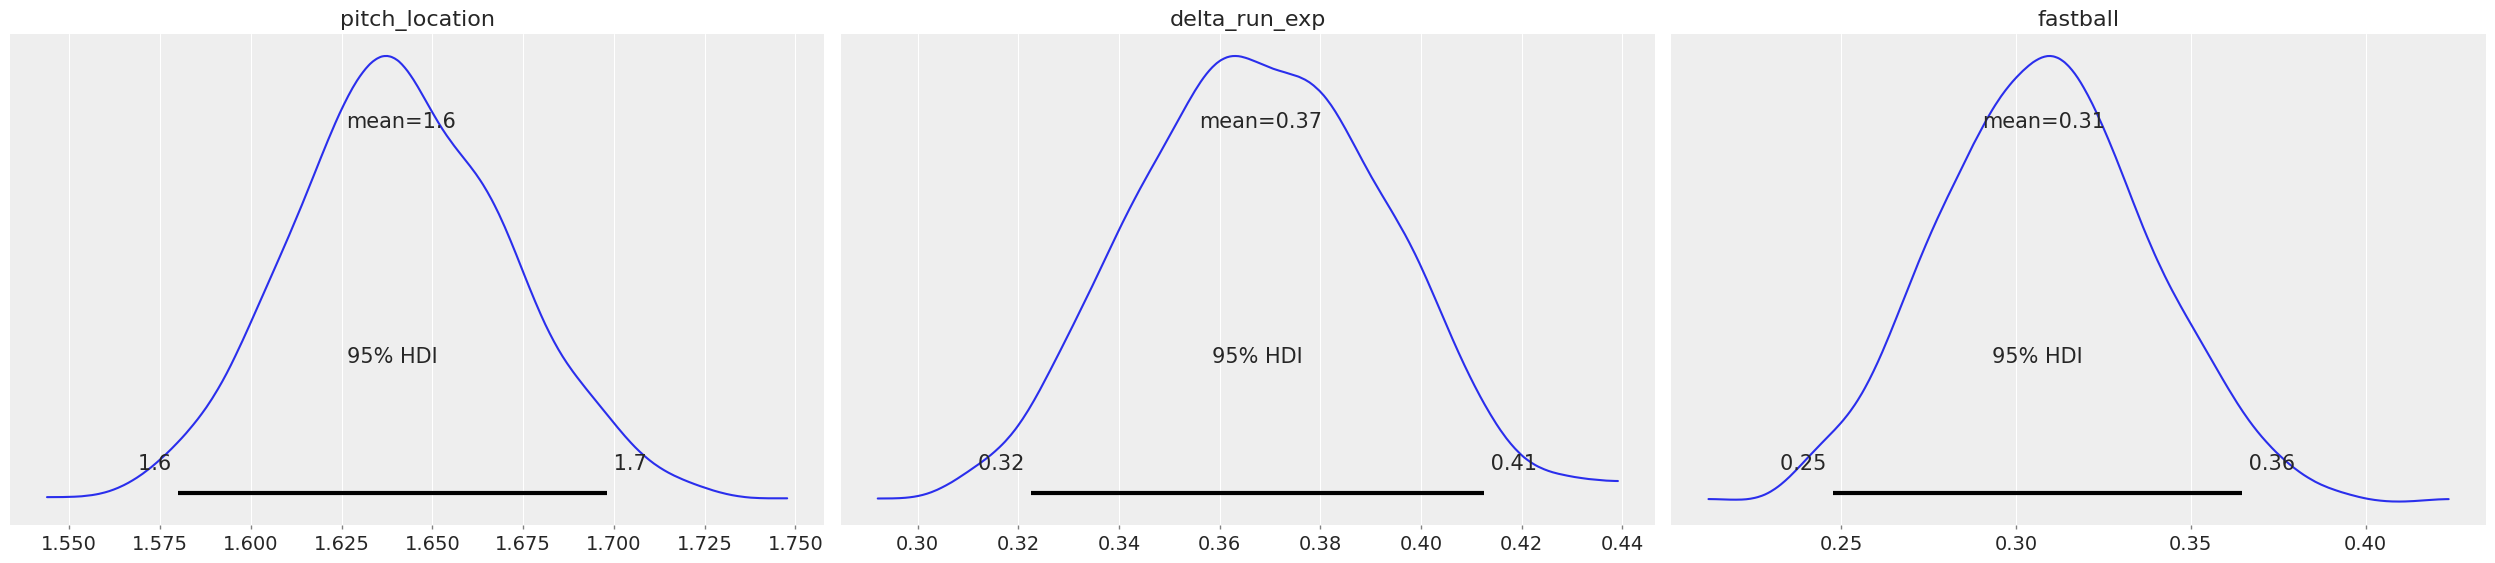

In [41]:
# Combine location, delta_run_exp, and fastball
with pm.Model() as m_locaiton_runExp_FB:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    pitch_location = -pm.HalfNormal("pitch_location", sigma=10)
    fastball = pm.HalfNormal("fastball", sigma=10) # Assuming the umpire has a harder time calling fastballs correctly because they are thrown faster
    delta_run_exp = -pm.HalfNormal("delta_run_exp", sigma=10) # Assuming umpire gets better in situations where more runs can be scored (he will be more focused)


    # Likelihood
    mu = intercept + (pitch_location*df['pitch_location']) + (delta_run_exp*df['delta_run_exp']) + (fastball*df['fastball'])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    y1 = pm.Bernoulli('y1', p=theta, observed=df['error_in_decision'])

    # ELPD_LOO
    print("Getting advi samples...")
    mean_field = pm.fit(method='advi', obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    # idata1 = pm.sample(draws=1000, idata_kwargs={"log_likelihood":True})
    # idata1.extend(pm.sample_posterior_predictive(idata1))
    # loocv_ump1["m1"] = idata1

print("Tracing mean field...")
trace_locaiton_runExp_FB= mean_field.sample(1000)

# add to model comparision dict
loocv_ump1["locaiton_runExp_FB"] = trace_locaiton_runExp_FB

print("Plotting posterior...")
az.plot_posterior(trace_locaiton_runExp_FB, var_names=['pitch_location', "delta_run_exp", 'fastball'], hdi_prob=0.95)

In [42]:
# =====================Get Accuracy=====================
# Init param samples
param_samples = {}

# Make predictions for each posterior sample
n_samples = len(trace_locaiton_runExp_FB.posterior['intercept'])
n_obs = len(df_test)

# Initialize predictions array
all_preds = np.zeros((n_samples, n_obs))

# Get samples from each param (generalized for any number of params)
for param in ['intercept', 'pitch_location', 'fastball', "delta_run_exp"]:
    param_samples[param] = trace_locaiton_runExp_FB.posterior[param].values.flatten()

# Make predictions
for i in range(n_samples):
  # Use df_test!
  mu = param_samples['intercept'][i] + (
      - (param_samples['pitch_location'][i]*df_test['pitch_location'])
      + (param_samples['fastball'][i]*df_test['fastball'])
      - (param_samples['delta_run_exp'][i]*df_test['delta_run_exp'])     # !!!!CHANGE THE SIGN HERE IF THE DISTRIBUTION IS NEGITIVE
      )
  all_preds[i, :] = 1 / (1 + np.exp(-mu))  # sigmoid function

# Make predictions
y_pred_proba = all_preds.mean(axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = f1_score(y_pred, df_test['error_in_decision'])
combined_f1["location_runExp_FB"] = accuracy

# print accuracy
print(f"F1: {accuracy}")
print(f"Number of Category 0: {np.sum(y_pred == 0)}")
print(f"Number of Category 1: {np.sum(y_pred == 1)}")

F1: 0.4079015768497661
Number of Category 0: 6366
Number of Category 1: 4359


Combining all 4 params

Getting advi samples...


Output()

Tracing mean field...
Plotting posterior...


array([<Axes: title={'center': 'pitch_location'}>,
       <Axes: title={'center': 'delta_run_exp'}>,
       <Axes: title={'center': 'fastball'}>,
       <Axes: title={'center': 'pitch_number'}>], dtype=object)

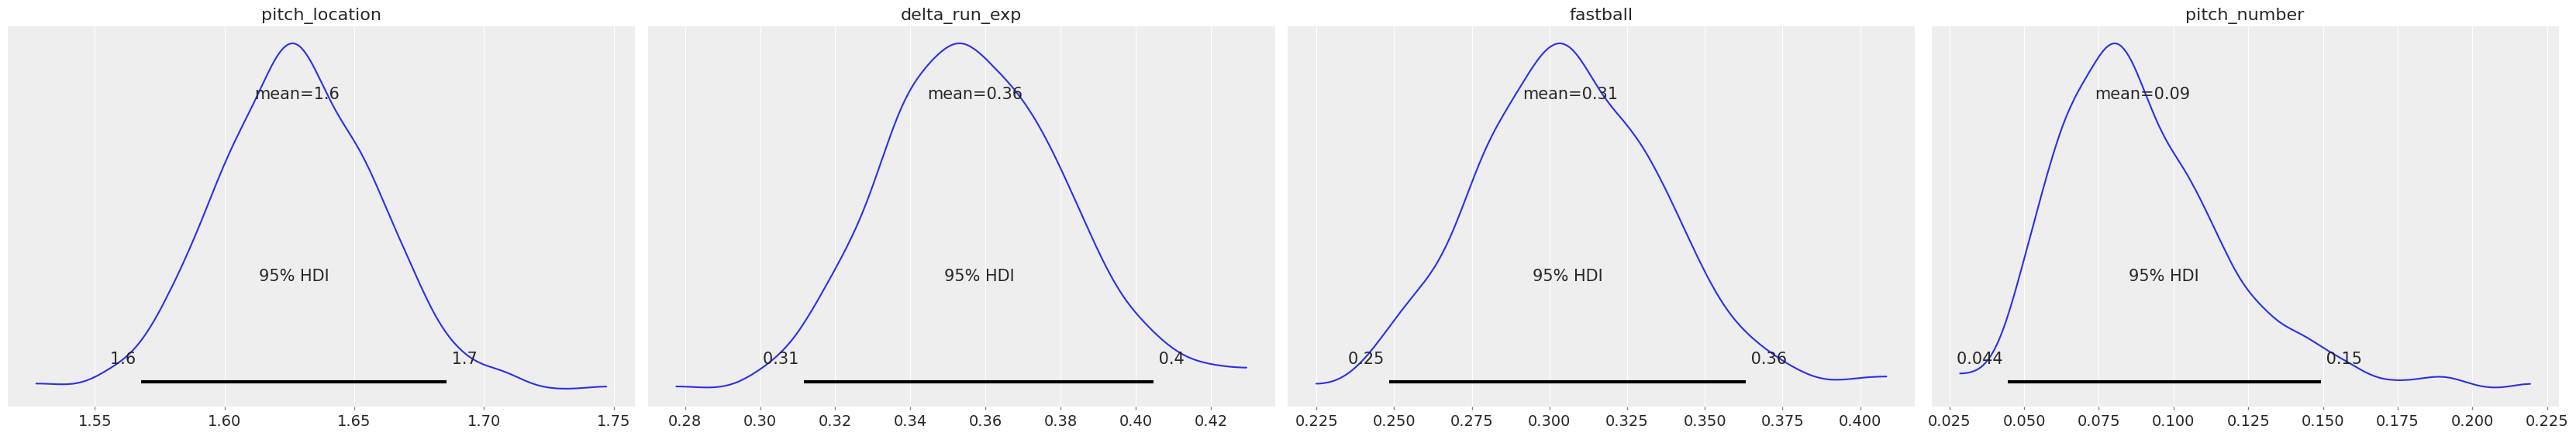

In [43]:
# Combine location, delta_run_exp, and fastball
with pm.Model() as m_4:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    pitch_location = -pm.HalfNormal("pitch_location", sigma=10)
    fastball = pm.HalfNormal("fastball", sigma=10) # Assuming the umpire has a harder time calling fastballs correctly because they are thrown faster
    delta_run_exp = -pm.HalfNormal("delta_run_exp", sigma=10) # Assuming umpire gets better in situations where more runs can be scored (he will be more focused)
    # Assuming umpire gets tired and less accurate the longer the at bat goes on
    # ^^^ This was incorrect, coefficient actually wants to be negitive, meaning he gets more accurate the longer the at bat goes on
    pitch_number = -pm.HalfNormal("pitch_number", sigma=10)


    # Likelihood
    mu = intercept + (pitch_location*df['pitch_location']) + (delta_run_exp*df['delta_run_exp']) + (fastball*df['fastball']) + (pitch_number*df['pitch_number'])
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    y1 = pm.Bernoulli('y1', p=theta, observed=df['error_in_decision'])

    # ELPD_LOO
    print("Getting advi samples...")
    mean_field = pm.fit(method='advi', obj_optimizer=pm.adagrad_window(learning_rate=1e-2))
    # idata1 = pm.sample(draws=1000, idata_kwargs={"log_likelihood":True})
    # idata1.extend(pm.sample_posterior_predictive(idata1))
    # loocv_ump1["m1"] = idata1

print("Tracing mean field...")
trace_locaiton_runExp_FB_num = mean_field.sample(1000)

# add to model comparision dict
loocv_ump1["locaiton_runExp_FB_num"] = trace_locaiton_runExp_FB_num

print("Plotting posterior...")
az.plot_posterior(trace_locaiton_runExp_FB_num, var_names=['pitch_location', "delta_run_exp", 'fastball','pitch_number'], hdi_prob=0.95)

In [44]:
# =====================Get Accuracy=====================
# Init param samples
param_samples = {}

# Make predictions for each posterior sample
n_samples = len(trace_locaiton_runExp_FB_num.posterior['intercept'])
n_obs = len(df_test)

# Initialize predictions array
all_preds = np.zeros((n_samples, n_obs))

# Get samples from each param (generalized for any number of params)
for param in ['intercept', 'pitch_location', 'fastball', "delta_run_exp", 'pitch_number']:
    param_samples[param] = trace_locaiton_runExp_FB_num.posterior[param].values.flatten()

# Make predictions
for i in range(n_samples):
  # Use df_test!
  mu = param_samples['intercept'][i] + (
      - (param_samples['pitch_location'][i]*df_test['pitch_location'])
      + (param_samples['fastball'][i]*df_test['fastball'])
      - (param_samples['delta_run_exp'][i]*df_test['delta_run_exp'])
      - (param_samples['delta_run_exp'][i]*df_test['delta_run_exp'])     # !!!!CHANGE THE SIGN HERE IF THE DISTRIBUTION IS NEGITIVE
      )
  all_preds[i, :] = 1 / (1 + np.exp(-mu))  # sigmoid function

# Make predictions
y_pred_proba = all_preds.mean(axis=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = f1_score(y_pred, df_test['error_in_decision'])
combined_f1["location_runExp_FB_num"] = accuracy

# print accuracy
print(f"F1: {accuracy}")
print(f"Number of Category 0: {np.sum(y_pred == 0)}")
print(f"Number of Category 1: {np.sum(y_pred == 1)}")

F1: 0.40921075760239056
Number of Category 0: 6448
Number of Category 1: 4277


Lastly, plot combined model F1 scores

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'locaiton_runExp'),
  Text(1, 0, 'fastball_runExp'),
  Text(2, 0, 'locaiton_number'),
  Text(3, 0, 'locaiton_fullCount'),
  Text(4, 0, 'location_runExp_FB'),
  Text(5, 0, 'location_runExp_FB_num')])

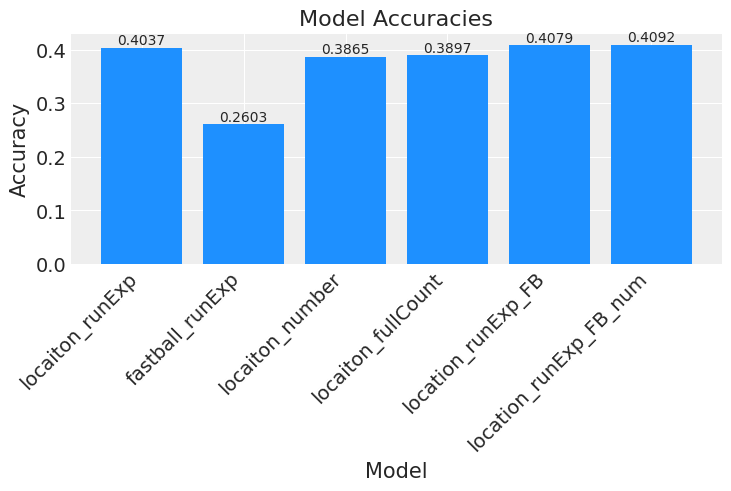

In [45]:
# Bar chart
import matplotlib.pyplot as plt

# Extract model names and accuracies
model_names = list(combined_f1.keys())
accuracies = list(combined_f1.values())

# Create bar chart
plt.bar(model_names, accuracies, color='dodgerblue')

# Add values on top of bars
for i, v in enumerate(accuracies):
    plt.text(i, v, str(round(v, 4)), ha='center', va='bottom')

# Customize chart
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracies")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability